# Lab 4: Parte 1 - Optimizacion Multiobjetivo y Metodo Simplex

- Jaime Andres Torres Bermejo - 202014866
- Elkin Rafael Cuello - 202215037

## EJERCICIO 1 (30%): Método eConstraint en Pyomo

Resuelva el mismo caso presentado en “multiobjetivoHopsCosts_sumasPonderadas.py”, pero implementando un nuevo método multiobjetivo llamado “el método multiobjetivo de eConstraint”. Implementar este método en Pyomo.

Para la implementación de este método, siga los siguientes pasos:
-La idea general del método se puede observar en la siguiente figura:

$$
max(f_{1}(x), f_{2}(x) \dots f_{p}(x)) \implies max(f_1(x)) st.
\begin{cases}
f_{2}(x) \geq e_{2}\\
f_{3}(x) \geq e_{3}\\
\dots\\
f_{p}(x) \geq e_{p}\\
\end{cases}
$$

De manera general, como se puede observar en la figura, si deseo maximizar (o minimizar) varias funciones (lado izquierdo de la figura), según este método solo debo dejar una única función como función objetivo general (lado derecho: max f1(x)) y las demas restricciones se convierten en restricciones adicionales a las que ya tenía el modelo. Por lo tanto, la función f2(x) pasa a convertirse en la restricción f2(x)≥e2;  la función f3(x) pasa a convertirse en la restricción f3(x)≥e3 y así sucesivamente. A los e1, e2, e3...etc se les llama los epsilon de cada función y corresponden a un valor númerico que debe ir cambiando para obtener el frente óptimo de pareto. En otras palabras, cada vez que cambiemos los epsilons, debemos guardar los valores de las funciones objetivo f1(x), f2(x)...fp(x) para luego obtener el frente óptimo de Pareto.

-La idea es entonces optimizar el mismo caso de “multiobjetivoHopsCosts_sumasPonderadas.py” pero NO usando sumas ponderadas sino el método de e-Constraint. Recuerde que el caso a resolver es el de la siguiente figura:


Donde deseamos encontrar una ruta que nos lleve de 1 a 5 mínimizando costos y hops.

Para implementar el método de e-Constraint al caso de la figura anterior, siga los siguientes pasos:
- Deseamos minimizar dos funciones, función de costo y función de hops. Con e-Constraint solo podemos dejar una única función como función objetivo general. Por ejemplo, podríamos dejar a la función de costo como función general.
- Agregamos entonces como restricción la función de hops: Fhops(x) ≤ epsilon. El epsilon debería tener un valor que permitiera que la función de hops sea factible según el escenario que estemos resolviendo. Por ejemplo, un valor de epsilon podría ser 5, o sea Fhops(x) ≤ 5. Si resolvemos el modelo con este valor de epsilon, la ruta de 1 a 5  sería la 1-3-4-5 y los valores de la funciones serían 15 para la función de costo y 3 para la de hops, obteniendo así un primer punto del frente de Pareto. Si empezamos a decrementar de a 1 el valor de epsilon, veremos que con epsilon=2 la ruta de 1 a 5 sería 1-2-5, generando los valores de 20 para la función de costo y 2 para la función de hops, obteniendo así un segundo punto del frente de Pareto. Si el epsilon es igual a 1, obtendríamos infactibilidad ya que no es posible encontrar una solución en la cual el número de hops sea 1 o menor a 1. De esta manera, la idea sería poner a cambiar el epsilon hasta donde sepamos que el modelo va a ser factible.
- Dado el item anterior, ud debe implementar el método de e-Constraint de tal forma que, al ejecutarlo UNA ÚNICA VEZ, este solucione el modelo para varios valores de Epsilon y así arrojar la gráfica del frente óptimo de Pareto.

No se encontró solución en la iteración con epsilon=0.0
(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).


Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).
Deleting model components (O_z).
Deleting model components (epsilon_constraint).


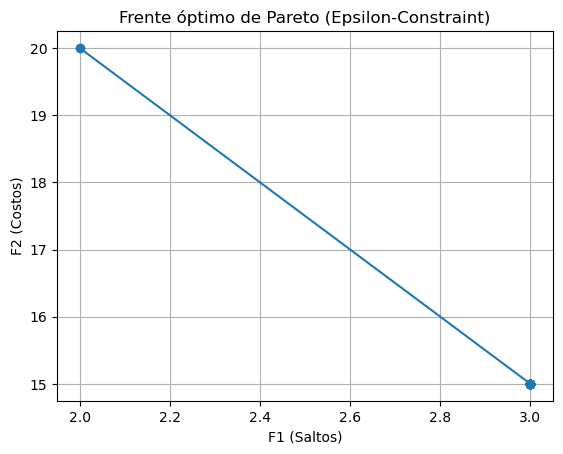

In [6]:
#Plot Imports
import matplotlib.pyplot as plt

#Pyomo Imports (Modelo Matematico)
from pyomo.environ import *
from pyomo.opt import SolverFactory

##############################################################################
##################### FUNCIONES ################################
##############################################################################

#FUNCION ELIMINAR COMPONENTE
def delete_component(Model, comp_name):
    list_del = [vr for vr in vars(Model)
                if comp_name == vr
                or vr.startswith(comp_name + '_index')
                or vr.startswith(comp_name + '_domain')]

    list_del_str = ', '.join(list_del)
    print('Deleting model components ({}).'.format(list_del_str))

    for kk in list_del:
        Model.del_component(kk)


##############################################################################
##################### MODELO ################################
##############################################################################

#Configuracion Iteraciones (Epsilon)----------------------------------------------------
numIteraciones = 11
iteraciones = range(numIteraciones)
epsilon_values = []  # Valores de epsilon para f1

for i in iteraciones:
    valorIter1 = i / (numIteraciones - 1)
    epsilon_values.append(valorIter1 * 20)  # Suponemos que el valor máximo de f1 es 20

#Creacion Modelo--------------------------------------------------------------
Model = ConcreteModel()

#sets & parameters------------------------------------------------------------
numNodes = 5
Model.N = RangeSet(1, numNodes)

#hops-----------------------------------------------------------------------
Model.h = Param(Model.N, Model.N, mutable=True, initialize=999)

Model.h[1, 2] = 1
Model.h[1, 3] = 1
Model.h[2, 5] = 1
Model.h[3, 4] = 1
Model.h[4, 5] = 1

#costos-----------------------------------------------------------------------
Model.c = Param(Model.N, Model.N, mutable=True, initialize=999)

Model.c[1, 2] = 10
Model.c[1, 3] = 5
Model.c[2, 5] = 10
Model.c[3, 4] = 5
Model.c[4, 5] = 5

#origen y destino-----------------------------------------------------------------------
s = 1
d = 5

#variables--------------------------------------------------------------------
Model.x = Var(Model.N, Model.N, domain=Binary)

# Excluir bucles dentro del mismo nodo (x[i, i] no debería existir)
def remove_self_loops_rule(Model, i):
    return Model.x[i, i] == 0
Model.self_loops = Constraint(Model.N, rule=remove_self_loops_rule)

# # FUNCIONES OBJETIVO*************************************************************

#Funcion hops
Model.f1 = sum(Model.x[i, j] * Model.h[i, j] for i in Model.N for j in Model.N)

#Funcion de costos
Model.f2 = sum(Model.x[i, j] * Model.c[i, j] for i in Model.N for j in Model.N)

#Restriccion nodo origen
def source_rule(Model, i):
    if i == s:
        return sum(Model.x[i, j] for j in Model.N if j != i) == 1  # Evitar x[i, i]
    else:
        return Constraint.Skip

Model.source = Constraint(Model.N, rule=source_rule)

#Restriccion nodo destino
def destination_rule(Model, j):
    if j == d:
        return sum(Model.x[i, j] for i in Model.N if i != j) == 1  # Evitar x[i, i]
    else:
        return Constraint.Skip

Model.destination = Constraint(Model.N, rule=destination_rule)

#Restriccion nodo intermedio
def intermediate_rule(Model, i):
    if i != s and i != d:
        return sum(Model.x[i, j] for j in Model.N if j != i) - sum(Model.x[j, i] for j in Model.N if j != i) == 0
    else:
        return Constraint.Skip

Model.intermediate = Constraint(Model.N, rule=intermediate_rule)

# PROCESO ITERATIVO: Método Epsilon-Constraint
f1_vec = []
f2_vec = []

for epsilon in epsilon_values:
    # Restriccion epsilon para f1
    Model.epsilon_constraint = Constraint(expr=Model.f1 <= epsilon)

    # Funcion objetivo minimizando f2
    Model.O_z = Objective(expr=Model.f2, sense=minimize)

    # Resolver el modelo
    result = SolverFactory('glpk').solve(Model)

    # Verificar si se encontró una solución factible
    if result.solver.status != 'ok' or result.solver.termination_condition != 'optimal':
        print(f'No se encontró solución en la iteración con epsilon={epsilon}')
        continue

    # Almacenar los valores de f1 y f2
    valorF1 = value(Model.f1)
    valorF2 = value(Model.f2)
    f1_vec.append(valorF1)
    f2_vec.append(valorF2)

    # Eliminar componentes para la siguiente iteracion
    delete_component(Model, 'O_z')
    delete_component(Model, 'epsilon_constraint')

# Graficar el frente de Pareto
plt.plot(f1_vec, f2_vec, 'o-')
plt.title('Frente óptimo de Pareto (Epsilon-Constraint)')
plt.xlabel('F1 (Saltos)')
plt.ylabel('F2 (Costos)')
plt.grid(True)
plt.show()

## EJERCICIO 2: Implementación del Algoritmo Simplex (40%)

Implemente el Algoritmo Simplex para solucionar el problema de Woodcarving:

$$
max(3 x_{1} + 2 x_{2})\\
s.a: \\
2x_{1} + x_{2} \leq 100\\
x_{1} + x_{2} \leq 80 \\
x_1 \leq 40
x_1 \geq 0 
c_2 \geq 0
$$

Para la implementación tenga en cuenta lo siguiente:

- Los parámetros de entrada del algoritmo deberían ser las coordenadas de cada uno de los vértices del espacio de soluciones factibles. Estas coordenadas se pueden calcular manualmente para luego ser ingresadas como parámetros de entrada en la solución.
- Para realizar la prueba de optimalidad, asuma que el FEV actual inicial podría ser cualquier vértice, es decir, que se asigne aleatoriamente.
- El algoritmo debería verificar la prueba de optimalidad a partir del FEV actual inicial hasta cumplir la prueba de optimalidad, y así, ofrecer la solución del problema. En otras, palabras el algoritmo debería arrojar el valor óptimo de Z, y los valores de X1 y X2.
- Cada vez que se ejecute el algoritmo, independientemente del FEV actual inicial aleatorio, la solución arrojada SIEMPRE debería ser la misma.

In [1]:
import numpy as np

def metodo_simplex(coef_objetivo, restricciones, limites):

    num_vars_decision = restricciones.shape[1]  # Número de variables de decisión
    num_restricciones = restricciones.shape[0]  # Número de restricciones

    restricciones = np.hstack([restricciones, np.eye(num_restricciones)])  # Añadir variables de holgura

    tabla = np.hstack([restricciones, limites.reshape(-1, 1)])  # Crear la tabla simplex
    
    coef_objetivo_extendido = np.hstack([coef_objetivo, np.zeros(num_restricciones + 1)])  # Extender c
    tabla = np.vstack([tabla, coef_objetivo_extendido])  # Agregar fila objetivo

    while True:
        columna_pivote = np.argmin(tabla[-1, :-1])  # Buscar la columna pivote
        if tabla[-1, columna_pivote] >= 0:  # Condición de parada
            break
        
        cocientes = tabla[:-1, -1] / tabla[:-1, columna_pivote]  # Cociente mínimo
        cocientes = np.where(cocientes > 0, cocientes, np.inf)
        fila_pivote = np.argmin(cocientes)  # Buscar la fila pivote

        elemento_pivote = tabla[fila_pivote, columna_pivote]
        tabla[fila_pivote, :] /= elemento_pivote  # Hacer 1 el elemento pivote

        for i in range(tabla.shape[0]):
            if i != fila_pivote:
                tabla[i, :] -= tabla[i, columna_pivote] * tabla[fila_pivote, :]  # Operaciones de fila

    solucion_optima = np.zeros(num_vars_decision)
    for i in range(num_vars_decision):
        columna = tabla[:-1, i]
        if np.count_nonzero(columna) == 1 and np.sum(columna) == 1:
            solucion_optima[i] = tabla[np.where(columna == 1)[0], -1]

    valor_optimo = tabla[-1, -1]

    return solucion_optima, valor_optimo

# Función objetivo (3x1 + 2x2)
coef_objetivo = np.array([-3, -2])  # Maximizar, por lo que coef_objetivo debe ser negativo.

# Restricciones
restricciones = np.array([
    [2, 1],  # 2x1 + x2 <= 100
    [1, 1],  # x1 + x2 <= 80
    [1, 0]   # x1 <= 40
])

limites = np.array([100, 80, 40])

resultado, z_optimo = metodo_simplex(coef_objetivo, restricciones, limites)

print(f"Solución óptima: x1 = {resultado[0]}, x2 = {resultado[1]}")
print(f"Valor óptimo de Z: {z_optimo}")

Solución óptima: x1 = 20.0, x2 = 60.0
Valor óptimo de Z: 180.0


C:\Users\Elkur\AppData\Local\Temp\ipykernel_35852\771672892.py:20: RuntimeWarning: divide by zero encountered in divide
  cocientes = tabla[:-1, -1] / tabla[:-1, columna_pivote]  # Cociente mínimo
C:\Users\Elkur\AppData\Local\Temp\ipykernel_35852\771672892.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  solucion_optima[i] = tabla[np.where(columna == 1)[0], -1]


# Lab 4: Parte 2 - Optimización multiobjetivo en problemas no lineales

- Jaime Andres Torres Bermejo - 202014866
- Elkin Rafael Cuello - 202215037

In [7]:
import matplotlib.pyplot as plt
import math
from pyomo.environ import *
from pyomo.opt import SolverFactory
solver = SolverFactory('ipopt')
import pandas as pd
import numpy as np

## Pregunta 1: Beneficio vs Unidades Vendidas

Una startup necesita aumentar las ventas de un producto a través de publicidad. Si la empresa gasta $a$ (medido en miles de dólares) en publicidad y cobra un precio de $p=10+0.38a$ dólares por unidad, entonces puede vender $1000-10p+20\sqrt{a}$ unidades del producto. El costo de producción por unidad del producto es $6$. Ayuda a la empresa a encontrar al menos 10 soluciones de Pareto óptimas y traza la frontera de Pareto entre los objetivos de maximizar el beneficio y maximizar el número de unidades vendidas.

### Parte I: Formulación del modelo matemático

Formula el problema matemático listando:
- Variables de decisión
- Función objetivo
- Restricciones

1. Variables de Decisión  
  - $ a = $ inversión en publicidad (miles de dólares)

2. Función Objetivo  
  - $Max :\ ventas\ unitarias(a) = f_1(a) $  
    - $ventas\ unitarias(a) = 1000-10p+20\sqrt{a}$  
    - Sustituyendo:  
      - $ ventas\ unitarias(a) = 1000-10(10+0.38a)+20\sqrt{a} $  
      - $ ventas\ unitarias(a) = 890-3.8a+20\sqrt{a} $  
    - $ Max :\ ventas\ unitarias(a) = f_1(a) = 890-3.8a+20\sqrt{a} $
    
  - $Max :\ beneficio(a) = f_2(a) $  
    - $ beneficio = ventas\ unitarias * margen - inversión$
    - $ beneficio = ventas\ unitarias * (precio - 6) - a $
    - Sustituyendo:  
      - $ beneficio(a) = ventas\ unitarias * ((10+0.38a) - 6) - a $
      - $ beneficio(a) = (890-3.8a+20\sqrt{a}) * (4+0.38a) - a $
    - $Max :\ beneficio(a) = f_2(a) = -1.444a^2 + 7.6\sqrt{a}*a + 80\sqrt{a} + 322a +3560 $

3. Restricciones  
  - $ a > 0 $

In [8]:

solver = SolverFactory('ipopt')

def construir_modelo():
    modelo = ConcreteModel()
    
    modelo.inversion_publicitaria = Var(bounds=(1e-6, None), initialize=1, within=NonNegativeReals)
    
    modelo.ventas = Expression(expr=890 - 3.8 * modelo.inversion_publicitaria + 20 * sqrt(modelo.inversion_publicitaria))
    
    modelo.rentabilidad = Expression(
        expr=-1.444 * (modelo.inversion_publicitaria ** 2) + 
        7.6 * modelo.inversion_publicitaria * sqrt(modelo.inversion_publicitaria) +
        80 * sqrt(modelo.inversion_publicitaria) + 322 * modelo.inversion_publicitaria + 3560
    )
    
    return modelo

### Parte II: Hallar los extremos de Pareto

Encontrar tanto la venta máxima como la ganancia máxima de unidades vendidas.

> Puedes usar `model.res1.deactivate()` para desactivar la restricción para esto


In [9]:
def optimizar_rentabilidad():
    modelo = construir_modelo()
    modelo.objetivo_rentabilidad = Objective(expr=modelo.rentabilidad, sense=maximize)
    solucion = solver.solve(modelo)
    
    if (solucion.solver.status == SolverStatus.ok) and (solucion.solver.termination_condition == TerminationCondition.optimal):
        rentabilidad_max = modelo.rentabilidad()
        publicidad_optima = modelo.inversion_publicitaria()
        ventas_optimas = modelo.ventas()
        return rentabilidad_max, publicidad_optima, ventas_optimas
    else:
        raise ValueError('No se pudo obtener una solución óptima para maximizar la rentabilidad.')

def optimizar_ventas():
    modelo = construir_modelo()
    modelo.objetivo_ventas = Objective(expr=modelo.ventas, sense=maximize)
    solucion = solver.solve(modelo)
    
    if (solucion.solver.status == SolverStatus.ok) and (solucion.solver.termination_condition == TerminationCondition.optimal):
        ventas_max = modelo.ventas()
        publicidad_optima = modelo.inversion_publicitaria()
        rentabilidad_optima = modelo.rentabilidad()
        return ventas_max, publicidad_optima, rentabilidad_optima
    else:
        raise ValueError('No se encontró una solución óptima para maximizar las ventas.')

try:
    rentabilidad_max, publicidad_rentabilidad, ventas_rentabilidad = optimizar_rentabilidad()
    print(f'Rentabilidad máxima: {rentabilidad_max}, Ventas: {ventas_rentabilidad}, Inversión publicitaria: {publicidad_rentabilidad}')
    
    ventas_max, publicidad_ventas, rentabilidad_ventas = optimizar_ventas()
    print(f'Ventas máximas: {ventas_max}, Rentabilidad: {rentabilidad_ventas}, Inversión publicitaria: {publicidad_ventas}')

except ValueError as e:
    print(e)

Rentabilidad máxima: 34517.67614272985, Ventas: 526.0235218036853, Inversión publicitaria: 162.9732771211362
Ventas máximas: 916.3157894736842, Rentabilidad: 6069.695291316627, Inversión publicitaria: 6.925207757551526


### Parte III: Graficar la frontera de Pareto

Encuentra al menos 10 puntos de Pareto-óptimos y traza la frontera de Pareto entre los objetivos de maximizar el beneficio y maximizar el número de unidades vendidas.

Implementen el método de **$\epsilon$-constraint** para encontrar el **frente óptimo de Pareto** en un problema de optimización multiobjetivo. La idea detrás de este método es optimizar un objetivo principal mientras se aplica una restricción sobre el otro objetivo, permitiendo obtener soluciones óptimas que representen diferentes compromisos entre ambos objetivos (en este caso, maximizar el **beneficio** y maximizar las **ventas unitarias**).

### Explicación del Método $\epsilon$-Constraint

1. **Definición del Problema**:  
   El problema tiene dos objetivos conflictivos:
   - **Maximizar el beneficio** ($f_2(a)$).
   - **Maximizar las ventas unitarias** ($f_1(a)$).
   
   Como estos objetivos están en conflicto (aumentar el beneficio podría reducir las ventas y viceversa), necesitamos encontrar un conjunto de soluciones óptimas donde no se puede mejorar un objetivo sin empeorar el otro, es decir, el **frente de Pareto**.

2. **¿Qué es el método $\epsilon$-Constraint?**:  
   El método $\epsilon$-constraint optimiza uno de los objetivos (por ejemplo, el beneficio) mientras que el otro objetivo se convierte en una restricción limitada por un valor $\epsilon$.
   
   En el código, lo que se hace es:
   - Primero, se **maximiza el beneficio** bajo una restricción que lo limita a un porcentaje de su valor máximo posible.
   - Luego, se optimiza la función de **ventas unitarias** asegurando que el beneficio no disminuya por debajo del valor encontrado en la primera etapa.

3. **Cómo se calculan los valores $\epsilon$ (fronteras)**:  
   Los valores $\epsilon$ en este caso se calculan como un porcentaje de la diferencia entre el **valor máximo** y el **valor mínimo** del beneficio. Este valor $\epsilon$ establece el límite superior para el beneficio en cada iteración. Así es como se asegura que el beneficio no supere un porcentaje del beneficio máximo posible, permitiendo así maximizar las ventas unitarias bajo ese límite.

   La fórmula para establecer este límite es:
   $$
   \text{profit\_limit} = \text{profit\_max} - (\text{profit\_max} - \text{profit\_min}) \times w1
   $$
   Donde:
   - **profit\_max** es el valor máximo del beneficio.
   - **profit\_min** es el valor mínimo del beneficio.
   - **w1** es un peso que varía entre 0 y 1
4. **Iteración para encontrar soluciones de Pareto**:  
   El código genera múltiples soluciones cambiando el valor de **w1** en el rango de 0 a 1. Esto permite explorar diferentes compromisos entre el beneficio y las ventas unitarias:
   - Cuando **w1 = 0**, se permite el beneficio máximo posible.
   - Cuando **w1 = 1**, se reduce el beneficio al mínimo y se maximizan las ventas.
   
   Cada vez que el valor de **w1** cambia, el modelo se resuelve nuevamente para encontrar un nuevo compromiso óptimo entre beneficio y ventas, generando así una solución del frente de Pareto.

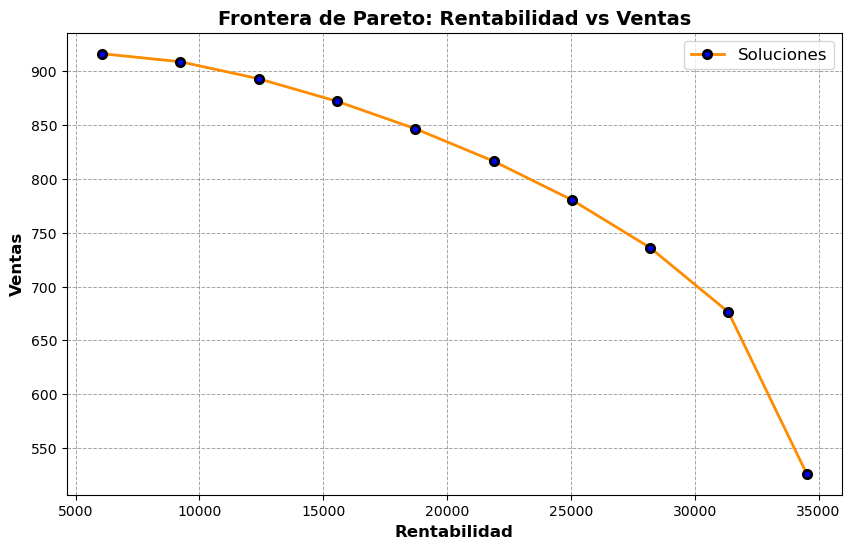

In [10]:
def frontera_pareto(rentabilidad_max, rentabilidad_min, pesos_w1):
    lista_rentabilidad = []
    lista_ventas = []
    
    for w1 in pesos_w1:
        umbral_rentabilidad = rentabilidad_max - (rentabilidad_max - rentabilidad_min) * w1
        modelo = construir_modelo()
        
        modelo.objetivo_ventas = Objective(expr=modelo.ventas, sense=maximize)
        
        modelo.restriccion_rentabilidad = Constraint(expr=modelo.rentabilidad >= umbral_rentabilidad)
        
        solucion = solver.solve(modelo)
        
        if (solucion.solver.status == SolverStatus.ok) and (solucion.solver.termination_condition == TerminationCondition.optimal):
            lista_rentabilidad.append(modelo.rentabilidad())
            lista_ventas.append(modelo.ventas())
        else:
            print(f'No se encontró una solución óptima para w1 = {w1}')
            lista_rentabilidad.append(None)
            lista_ventas.append(None)
    
    lista_rentabilidad = [r for r in lista_rentabilidad if r is not None]
    lista_ventas = [v for v in lista_ventas if v is not None]
    
    return lista_rentabilidad, lista_ventas

def dibujar_frontera_pareto(lista_rentabilidad, lista_ventas):
    plt.figure(figsize=(10,6))
    plt.plot(lista_rentabilidad, lista_ventas, 'o-', color='darkorange', linewidth=2, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black', label='Soluciones')
    plt.xlabel('Rentabilidad', fontsize=12, fontweight='bold')
    plt.ylabel('Ventas', fontsize=12, fontweight='bold')
    plt.title('Frontera de Pareto: Rentabilidad vs Ventas', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
    plt.legend(loc='best', fontsize=12)
    plt.show()

pesos_w1 = np.linspace(0, 1, 10)
lista_rentabilidad, lista_ventas = frontera_pareto(rentabilidad_max, rentabilidad_ventas, pesos_w1)

dibujar_frontera_pareto(lista_rentabilidad, lista_ventas)

### Explicación del algoritmo

Este algoritmo busca trazar la frontera de Pareto para el problema planteado, en el que se maximizan dos objetivos en conflicto: rentabilidad y ventas. La función frontera_pareto se encarga de calcular los valores óptimos de rentabilidad y ventas para diferentes pesos de importancia de la rentabilidad (pesos_w1), donde cada peso representa una preferencia relativa entre los dos objetivos. Para cada peso, el algoritmo ajusta el umbral mínimo de rentabilidad y resuelve el modelo de optimización, maximizando las ventas sujetas a la restricción de rentabilidad establecida. Los resultados de rentabilidad y ventas se almacenan en listas si se encuentra una solución óptima para el modelo. Finalmente, la función dibujar_frontera_pareto grafica las soluciones óptimas encontradas en una gráfica de Pareto, mostrando la relación entre rentabilidad y ventas.

### Parte (d): Discusión

Supongamos que la empresa startup ahora decide que, aunque ambos objetivos son importantes, maximizar el número de unidades vendidas es más importante que maximizar el beneficio. ¿Qué sugerencias le darías a la empresa basándote en tus resultados de las partes (b) y (c)?

#### **Respuesta:**

Basándome en los resultados obtenidos en las partes (b) y (c), si la empresa valora más maximizar el número de unidades vendidas, le sugeriría enfocarse en soluciones donde el objetivo de ventas se priorice en la frontera de Pareto. Específicamente, podría elegir estrategias de inversión publicitaria que se encuentren en el extremo de la curva de Pareto donde las ventas son mayores, aceptando un posible sacrificio en la rentabilidad. Sin embargo, es importante que la empresa evalúe cuidadosamente hasta qué punto puede reducir la rentabilidad sin comprometer su sostenibilidad a largo plazo, de forma que encuentre un equilibrio.